# Extract all the data of all the scans

This notebook is a *heavily* adapted version of https://github.com/habi/EAWAG/blob/main/DataWrangling.ipynb, specifically for the talk at the Institute seminar in 2024.

In [1]:
# Load the python modules we need
import platform
import os
import glob
import pandas
import imageio
import numpy
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask_image.imread
from dask.distributed import Client, LocalCluster
import skimage
from tqdm import notebook

In [2]:
# Load our own log file parsing code
from BrukerSkyScanLogfileRuminator.parsing_functions import *

In [3]:
# Set dask temporary folder
# Do this before creating a client: https://stackoverflow.com/a/62804525/323100
import tempfile
if 'Linux' in platform.system():
    # Check if me mounted the FastSSD, otherwise go to standard tmp file
    if os.path.exists(os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')):
        tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD', 'tmp')
    else:
        tmp = tempfile.gettempdir()
elif 'Darwin' in platform.system():
    tmp = tempfile.gettempdir()
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\tmp')
    else:
        tmp = os.path.join('D:\\tmp')
dask.config.set({'temporary_directory': tmp})
print('Dask temporary files go to %s' % dask.config.get('temporary_directory'))

Dask temporary files go to /media/habi/Fast_SSD/tmp


In [4]:
from dask.distributed import Client
client = Client()

/home/habi/anaconda3/envs/seminar24/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45379 instead
  warnings.warn(


In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45379/status,
Dashboard: http://127.0.0.1:45379/status,Workers: 8
Total threads: 32,Total memory: 125.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43877,Workers: 8
Dashboard: http://127.0.0.1:45379/status,Total threads: 32
Started: Just now,Total memory: 125.79 GiB
Comm: tcp://127.0.0.1:45253,Total threads: 4
Dashboard: http://127.0.0.1:39717/status,Memory: 15.72 GiB
Nanny: tcp://127.0.0.1:46341,


In [6]:
print('You can see what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can see what DASK is doing at "http://localhost:45379/status"


In [7]:
# Set up figure defaults for the talk
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['savefig.transparent'] = True
# Set seaborn theme
seaborn.set_theme(
    context='talk',
    style='darkgrid',
)

In [8]:
Root = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD', 'EAWAG')
print('We are loading all the data from %s' % Root)

We are loading all the data from /media/habi/Fast_SSD/EAWAG


In [9]:
# Make directory for output
# For these notebooks, we simply dump the images one directory up into the relevant 'images' folder
OutPutDir = os.path.join('..', 'images', 'EAWAG')
print('We are saving all the output to %s' % OutPutDir)
os.makedirs(OutPutDir, exist_ok=True)

We are saving all the output to ../images/EAWAG


In [10]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [11]:
# Get *all* log files, unsorted but fast
Data['LogFile'] = [os.path.join(root, name)
                   for root, dirs, files in os.walk(Root)
                   for name in files
                   if name.endswith((".log"))]

In [12]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [13]:
# Get rid of all non-rec logfiles
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'rectmp.log' in row.LogFile:
        Data.drop([c], inplace=True)
# Reset dataframe index
Data = Data.reset_index(drop=True)

In [14]:
# Generate us some meaningful colums
Data['Fish'] = [l[len(Root) + 1:].split(os.sep)[0] for l in Data['LogFile']]
Data['Scan'] = ['.'.join(l[len(Root) + 1:].split(os.sep)[1:-1]) for l in Data['LogFile']]

In [15]:
# Get parameters related to scan from logfiles
Data['Voxelsize'] = [pixelsize(log) for log in Data['LogFile']]
Data['Voltage'] = [voltage(log) for log in Data['LogFile']]
Data['Current'] = [current(log) for log in Data['LogFile']]
Data['Filter'] = [whichfilter(log) for log in Data['LogFile']]
Data['Exposuretime'] = [exposuretime(log) for log in Data['LogFile']]
Data['Scanner'] = [scanner(log) for log in Data['LogFile']]
Data['Averaging'] = [averaging(log) for log in Data['LogFile']]
Data['Scan date'] = [scandate(log) for log in Data['LogFile']]
Data['ProjectionSize'] = [projection_size(log) for log in Data['LogFile']]
Data['RotationStep'] = [rotationstep(log) for log in Data['LogFile']]
Data['ThreeSixty'] = [threesixtyscan(log) for log in Data['LogFile']]

In [16]:
# Get parameters related to reconstruction from logfiles
Data['ReconstructionSize'] = [reconstruction_size(log) for log in Data['LogFile']]
Data['Grayvalue'] = [reconstruction_grayvalue(log) for log in Data['LogFile']]
Data['RingartefactCorrection'] = [ringremoval(log) for log in Data['LogFile']]
Data['BeamHardeningCorrection'] = [beamhardening(log) for log in Data['LogFile']]
Data['ROI'] = [region_of_interest(log) for log in Data['LogFile']]
Data['Duration'] = [duration(log) for log in Data['LogFile']]
Data['Stacks'] = [stacks(log) for log in Data['LogFile']]

In [17]:
# The iee research storage folder contains some folders with scans done by Kassandra on a SkyScan1273.
# Exclude those, since they are not part of this study, we just looked at them to help her.
for c, row in Data.iterrows():
    if '1273' in row.Scanner:
        # print('Dropping %s from our dataframe' % row.LogFile[len(Root)+1:])
        Data.drop([c], inplace=True)
# Reset dataframe index
Data = Data.reset_index(drop=True)

In [18]:
# The iee research storage folder contains folders with scans of only teeth, done as a small pilot study.
# Exclude those, since they are not part of this study.
for c, row in Data.iterrows():
    if 'Teeth' in row.Folder:
        # print('Dropping %s from our dataframe' % row.LogFile[len(Root)+1:])
        Data.drop([c], inplace=True)
# Reset dataframe index
Data = Data.reset_index(drop=True)

In [19]:
# Sort dataframe on fishes and scans
Data.sort_values(by=['Fish', 'Scan'], inplace=True)
# Reset dataframe index
Data = Data.reset_index(drop=True)

In [20]:
# How many fishes did we scan?
# We scanned six 'BucketOfFish' so subtract those :)
print('We have %s unique names in our corpus of scans' % (len(Data.Fish.unique()) - 6))
print('We performed %s scans in total' % len(Data.Scan))

We have 133 unique names in our corpus of scans
We performed 375 scans in total


In [21]:
Data['Total Duration'] = [st * stk for st, stk in zip(Data['Duration'], Data['Stacks'])]

In [26]:
# Get an overview of the total scanning time
# Nice output based on https://stackoverflow.com/a/8907407/323100
total_seconds = int(Data['Total Duration'].sum())
hours, remainder = divmod(total_seconds, 60 * 60)
minutes, seconds = divmod(remainder, 60)
print('In total, we scanned for %s hours and %s minutes' % (hours, minutes))
for machine in Data['Scanner'].unique():
    total_seconds = int(Data[Data['Scanner'] == machine]['Total Duration'].sum())
    hours, remainder = divmod(total_seconds, 60 * 60)
    minutes, seconds = divmod(remainder, 60)
    print('\t - Of these, we scanned %s hours and %s minutes on the %s,'
          ' for %s scans' % (hours,
                             minutes,
                             machine,
                             len(Data[Data['Scanner'] == machine])))

In total, we scanned for 1104 hours and 53 minutes
	 - Of these, we scanned 840 hours and 51 minutes on the SkyScan 2214, for 337 scans
	 - Of these, we scanned 264 hours and 1 minutes on the SkyScan 1272, for 38 scans


In [27]:
# We scanned six 'buckets of fish', so subtract those :)
print('We scanned %0.f fishes' % (len(Data.Fish.unique()) - 6))

We scanned 133 fishes


In [28]:
print('We did a total of %s scans' % len(Data))

We did a total of 375 scans


In [29]:
print('We perfomed %s scans with "head" in their folder name' % len(Data[Data['Scan'].str.contains('head')]))

We perfomed 104 scans with "head" in their folder name


In [30]:
# for c, st in enumerate(['darkgrid',
#                         'whitegrid',
#                         'dark',
#                         'white',
#                         'ticks']):
#     seaborn.set_style(style=st)    
#     seaborn.boxenplot(Data.Voxelsize, color='#E6002E')
#     plt.ylim([0,50])
#     plt.title(st)   
#     plt.show()

In [31]:
MikkisFile = sorted(glob.glob(os.path.join(Root, '*CTscanFishList.xlsx')))[0]
# Read excel file and use the first column as index
print('Reading in %s' % MikkisFile)
DataMikki = pandas.read_excel(MikkisFile)

Reading in /media/habi/Fast_SSD/EAWAG/2022.12.13_CTscanFishList.xlsx


In [32]:
for i in DataMikki:
    print(i)

Fishec
FieldID
OtherID
ReplacementID
Fishec_ScannedSpecimens
Length(cm)
TemporaryJar
Genus
Species
Ecology
Replicates
Scan date
HeadScan
OralJawScan
UpperOralJaw
LowerOralJaw
PharyngealJawScan
UpperPharyngealJaw
LowerPharyngealJaw
ScanComments
QualityChecked
Unnamed: 21
SpecimenReturned
Comments


In [33]:
text = []
for i in DataMikki.Ecology.dropna():
    text.append(i)

In [34]:
text = ('.').join(text)

In [35]:
from wordcloud import WordCloud
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

In [36]:
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % numpy.random.randint(60, 100)

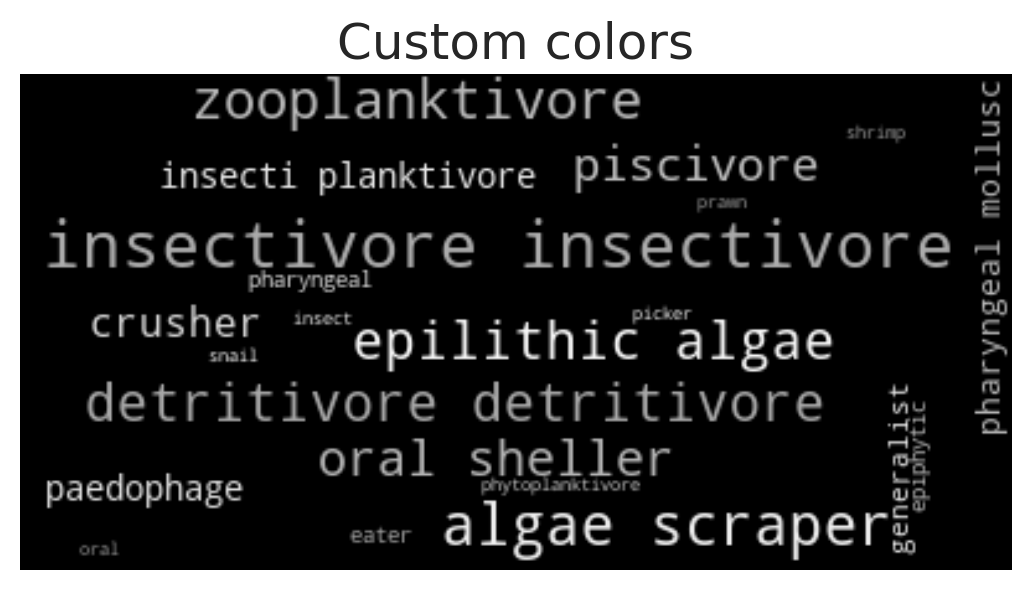

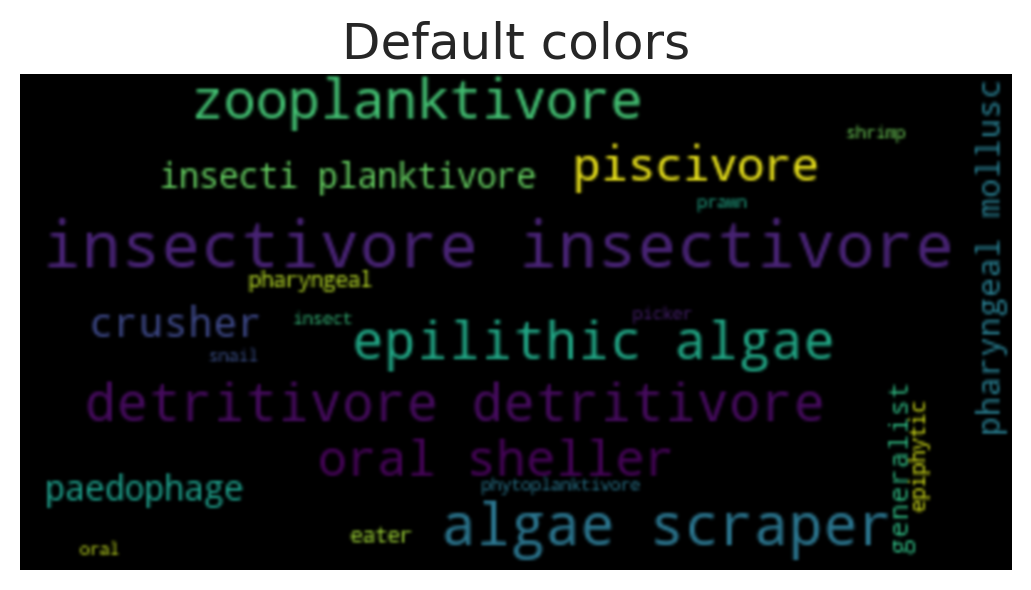

In [37]:
wc = WordCloud(random_state=1).generate(text)
# store default colored image
default_colors = wc.to_array()
plt.title("Custom colors")
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
wc.to_file("a_new_hope.png")
plt.axis("off")
plt.figure()
plt.title("Default colors")
plt.imshow(default_colors, interpolation="bicubic")
plt.axis("off")
plt.show()

In [40]:
sorted(DataMikki['Length(cm)'].unique())

[5.5,
 7.25,
 13.25,
 nan,
 6.0,
 6.2,
 6.5,
 7.0,
 7.5,
 7.9,
 8.0,
 8.5,
 9.0,
 9.5,
 10.0,
 10.5,
 11.0,
 11.25,
 11.5,
 12.0,
 12.5,
 13.0,
 13.5,
 14.0,
 14.5,
 15.0,
 15.5,
 16.0,
 17.0,
 18.0]

In [41]:
# Massage some values, so we can plot *all* values nicely
DataMikki['Length(cm)'].replace('?', numpy.nan, inplace=True)
DataMikki['Length(cm)'].replace('measure SL', numpy.nan, inplace=True)
DataMikki['Length(cm)'].replace('< 6', 5.5, inplace=True)
DataMikki['Length(cm)'].replace('< 7', 6.5, inplace=True)
DataMikki['Length(cm)'].replace('LE < 7', 6.5, inplace=True)

Plot the length of all the fish, so we can 'visualize' them for the audience.
In one of the last seminars, a discussion sprung up about violin plots, so we deliberately show them here again :)

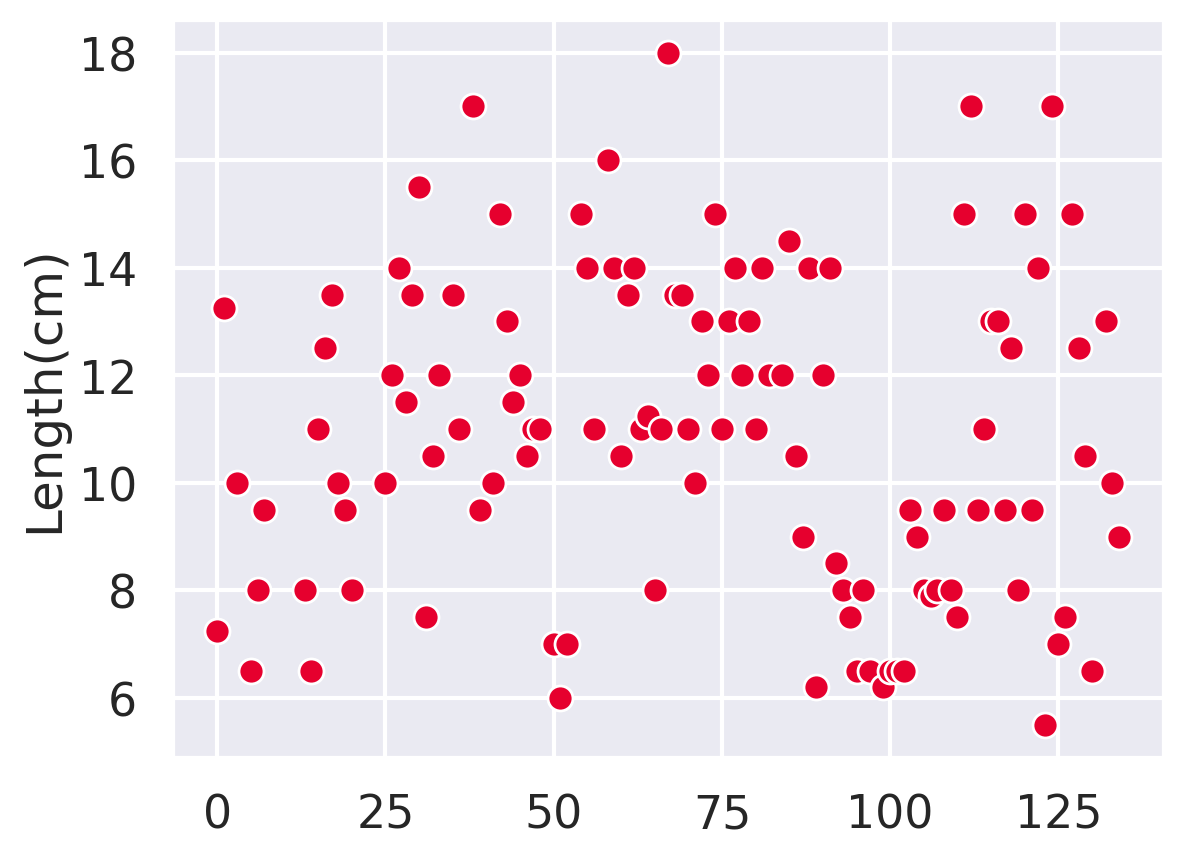

In [42]:
# Plot fish lengths
seaborn.scatterplot(DataMikki['Length(cm)'], color='#E6002E', linewidth=1)
plt.show()

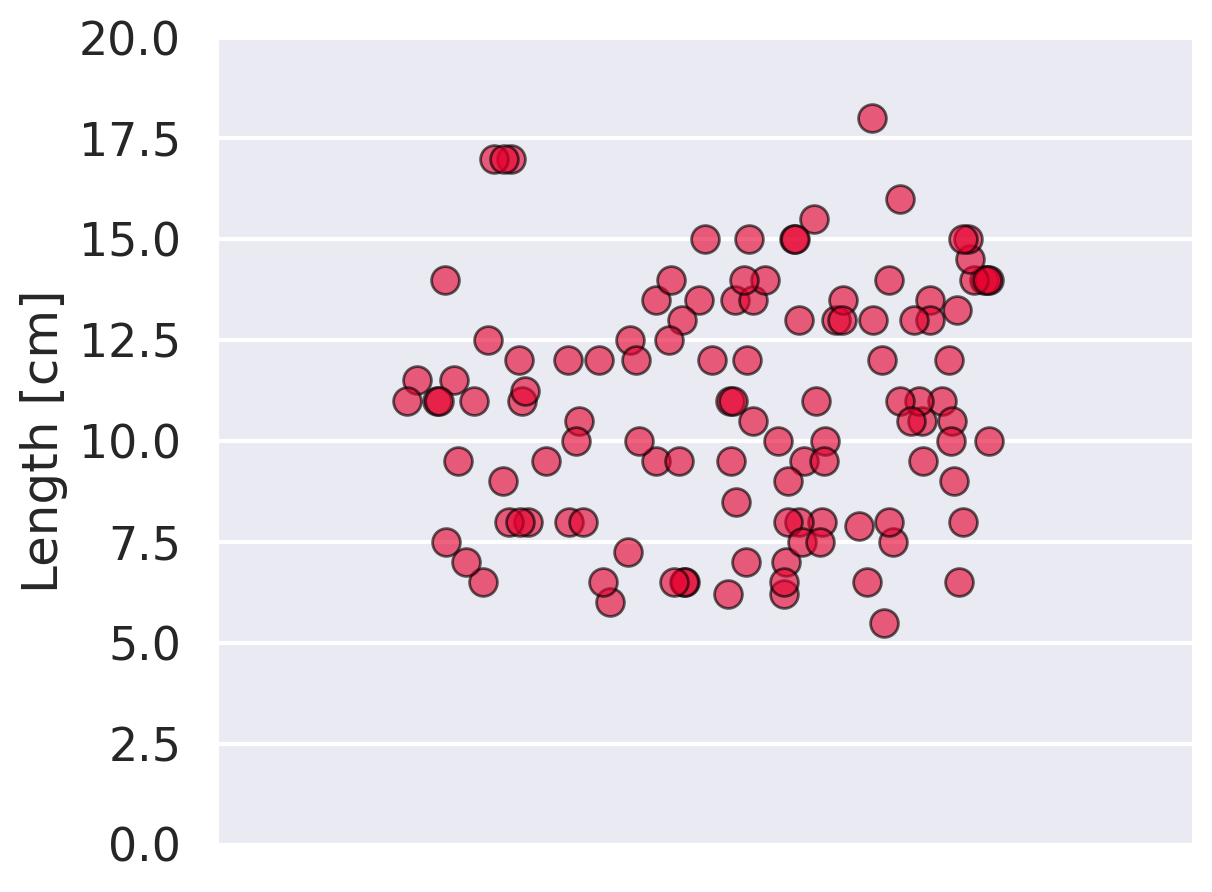

In [43]:
# Plot fish lengths
seaborn.stripplot(DataMikki['Length(cm)'], color='#E6002E', size=10, edgecolor='black', linewidth=1, jitter=0.618/2, alpha=0.618)
plt.ylim([0,20])
plt.ylabel('Length [cm]')
seaborn.despine()
plt.tight_layout()
plt.savefig(os.path.join(OutPutDir, 'lengths.plot.png'))

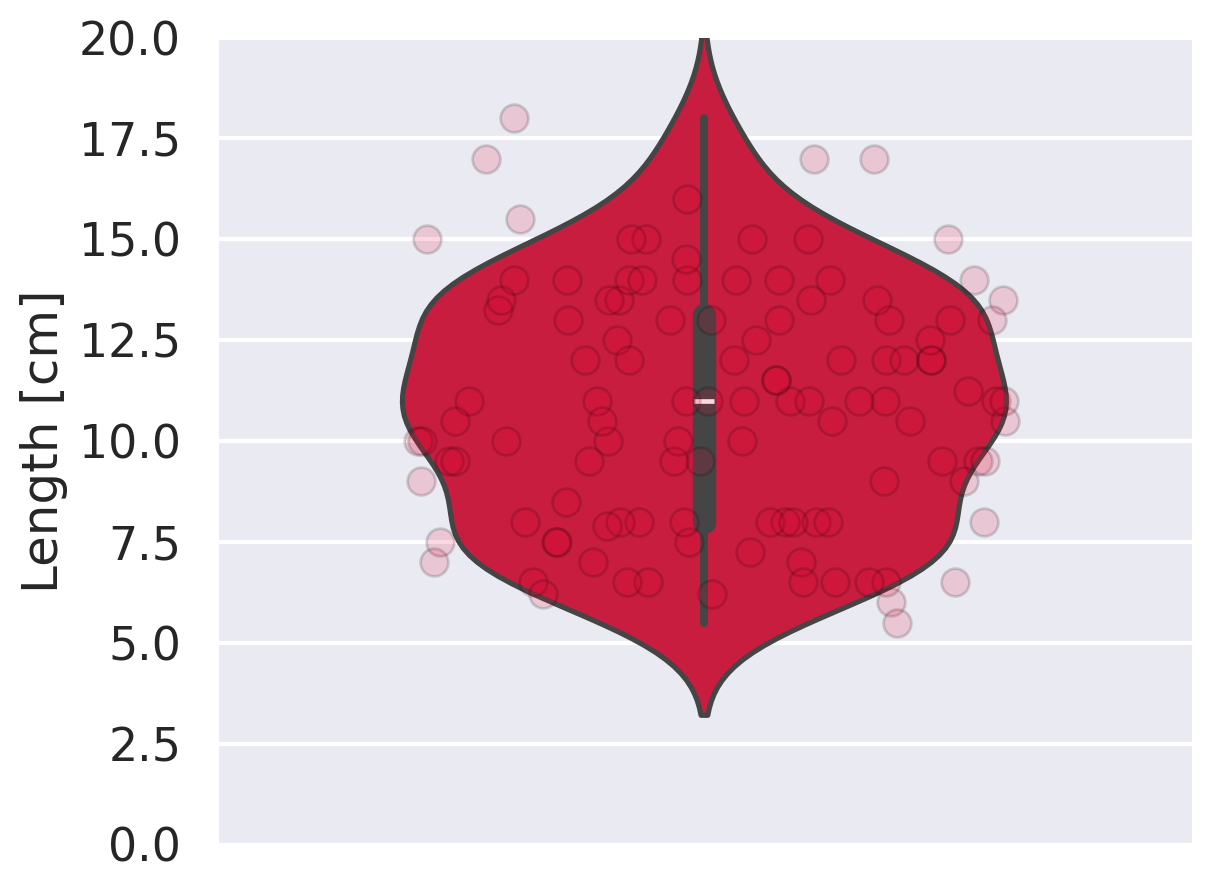

In [44]:
# Plot fish lengths
seaborn.stripplot(DataMikki['Length(cm)'], color='#E6002E', size=10, edgecolor='black', linewidth=1, jitter=0.618/2, alpha=0.618/4)
seaborn.violinplot(DataMikki['Length(cm)'], color='#E6002E', width=0.6187)
plt.ylim([0,20])
plt.ylabel('Length [cm]')
seaborn.despine()
plt.tight_layout()
plt.savefig(os.path.join(OutPutDir, 'lengths.violinplot.png'))

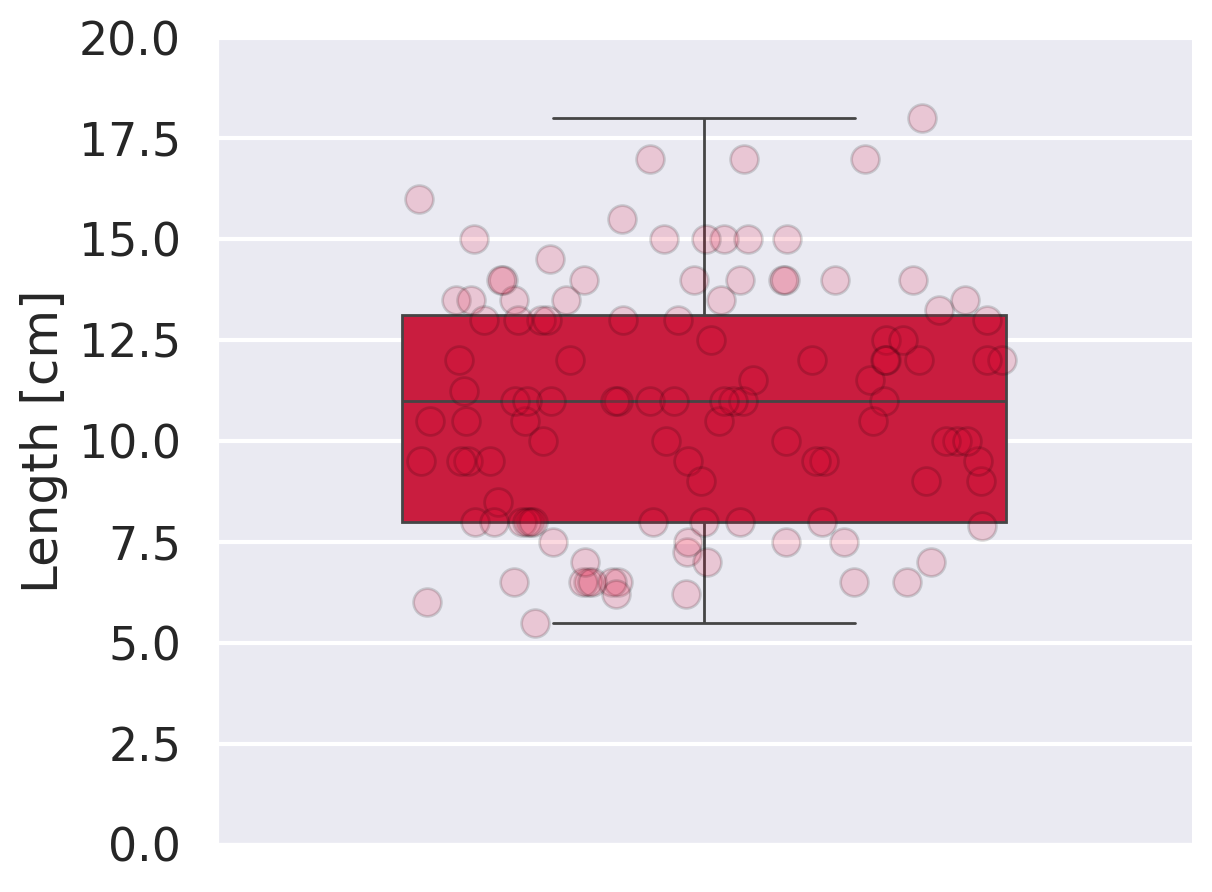

In [45]:
# Plot fish lengths
seaborn.stripplot(DataMikki['Length(cm)'], color='#E6002E', size=10, edgecolor='black', linewidth=1, jitter=0.618/2, alpha=0.618/4)
seaborn.boxplot(DataMikki['Length(cm)'], color='#E6002E', width=0.6187)
plt.ylim([0,20])
plt.ylabel('Length [cm]')
seaborn.despine()
plt.tight_layout()
plt.savefig(os.path.join(OutPutDir, 'lengths.boxplot.png'))

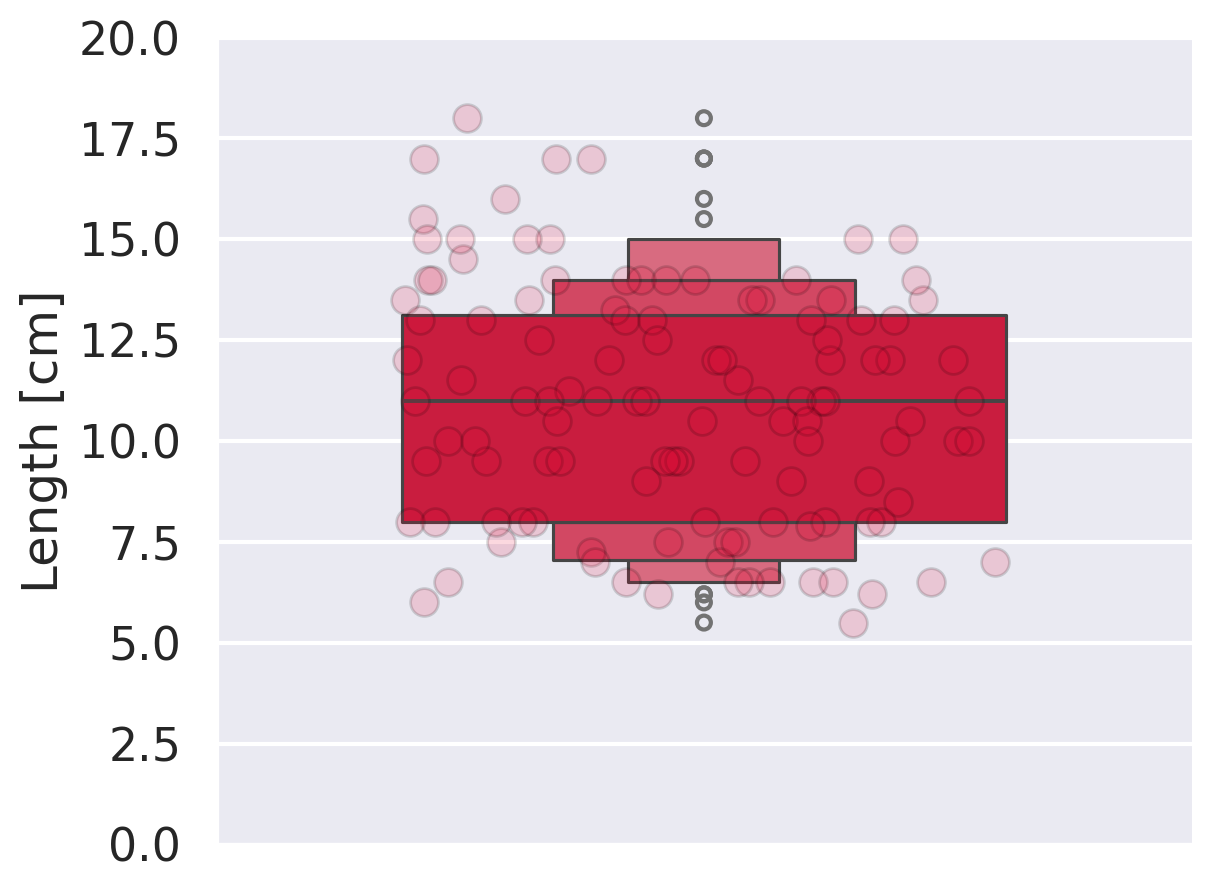

In [46]:
# Plot fish lengths
seaborn.stripplot(DataMikki['Length(cm)'], color='#E6002E', size=10, edgecolor='black', linewidth=1, jitter=0.618/2, alpha=0.618/4)
seaborn.boxenplot(DataMikki['Length(cm)'], color='#E6002E', width=0.6187)
plt.ylim([0,20])
plt.ylabel('Length [cm]')
seaborn.despine()
plt.tight_layout()
plt.savefig(os.path.join(OutPutDir, 'lengths.boxenplot.png'))
plt.show()

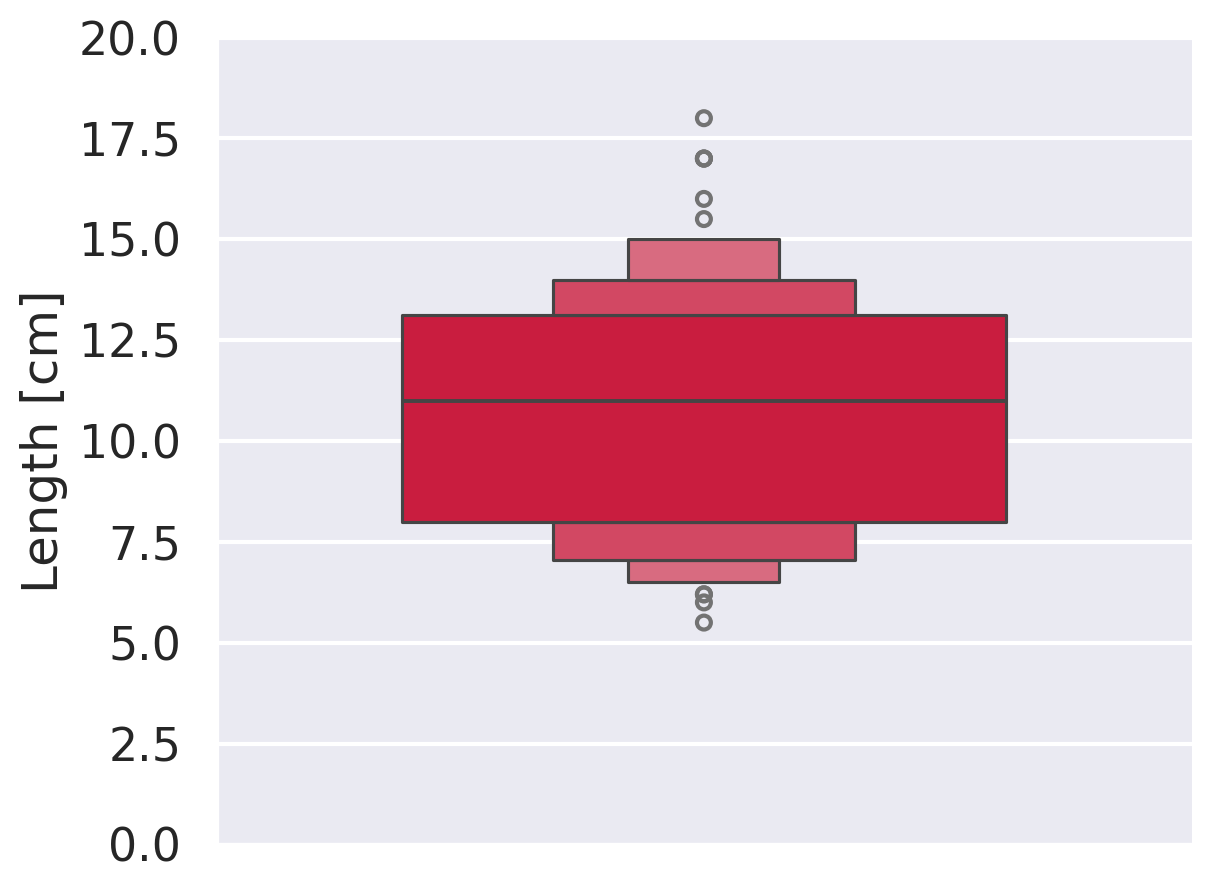

In [47]:
# Plot fish lengths
seaborn.boxenplot(DataMikki['Length(cm)'], color='#E6002E', width=0.6187)
plt.ylim([0,20])
plt.ylabel('Length [cm]')
seaborn.despine()
plt.tight_layout()
plt.savefig(os.path.join(OutPutDir, 'lengths.boxenplot.only.png'))
plt.show()

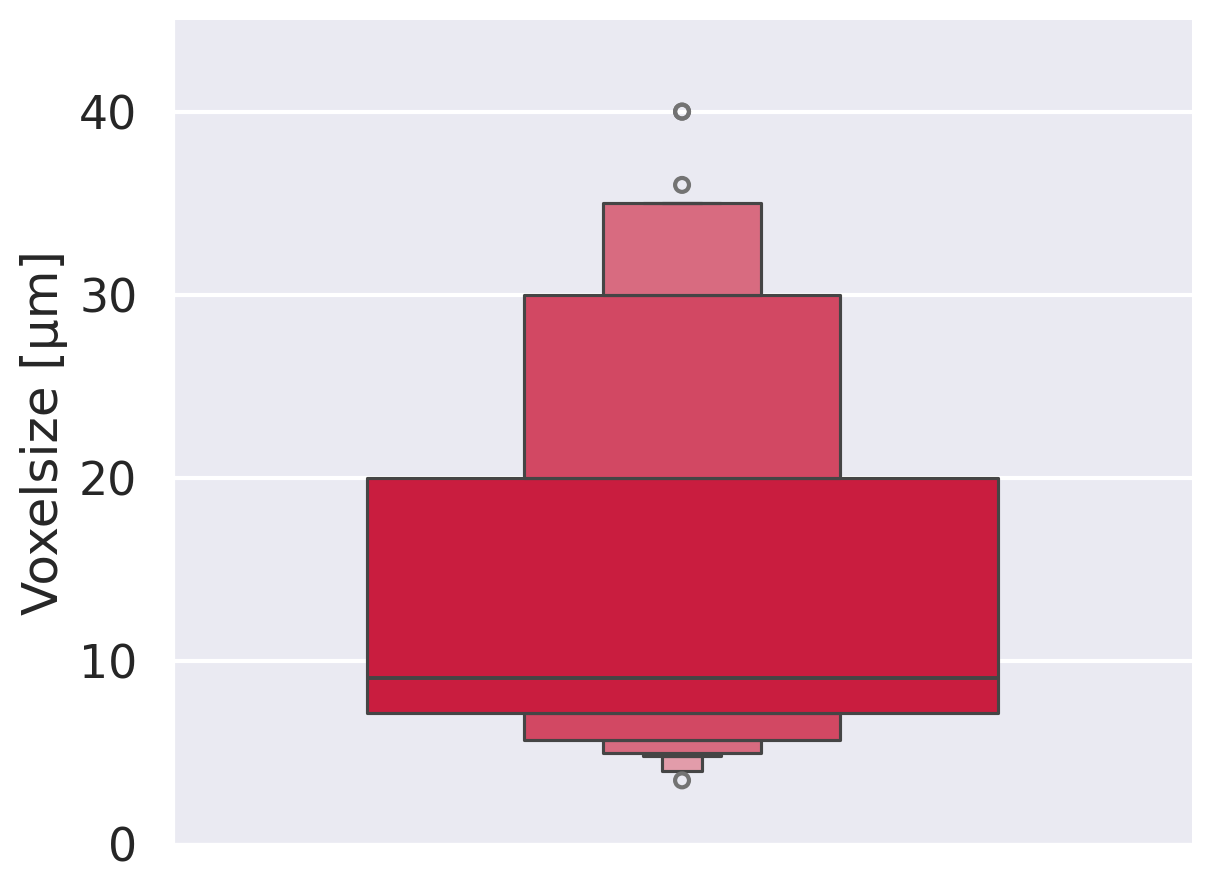

In [49]:
# Plot fish lengths
seaborn.boxenplot(Data['Voxelsize'], color='#E6002E', width=0.6187)
plt.ylabel('Voxelsize [μm]')
plt.ylim([0,45])
seaborn.despine()
plt.tight_layout()
plt.savefig(os.path.join(OutPutDir, 'voxelsizes.png'))
plt.show()

In [50]:
# Let's only talk about one fish
fish = '104016'

In [51]:
# Get rid of all other fish, so we can easily see what we talk about
for c, row in Data.iterrows():
    if fish not in row.Fish:
        Data.drop([c], inplace=True)
Data = Data.reset_index(drop=True)

In [52]:
# Data[Data.isin([fish])]
Data

,LogFile,Folder,Fish,Scan,Voxelsize,Voltage,Current,Filter,Exposuretime,Scanner,...,RotationStep,ThreeSixty,ReconstructionSize,Grayvalue,RingartefactCorrection,BeamHardeningCorrection,ROI,Duration,Stacks,Total Duration
0,/media/habi/Fast_SSD/EAWAG/104016_Enterochromi...,/media/habi/Fast_SSD/EAWAG/104016_Enterochromi...,104016_Enterochromis_I_cinctus_St_E,head.rec,13.001449,70.0,137.0,False,740,SkyScan 2214,...,0.2,False,"(1488, 864)",0.165210,NaN,NaN,"(1187, 322, 23, 1514)",2359.0,3,7077.0
1,/media/habi/Fast_SSD/EAWAG/104016_Enterochromi...,/media/habi/Fast_SSD/EAWAG/104016_Enterochromi...,104016_Enterochromis_I_cinctus_St_E,jaw.rec,5.000014,60.0,166.0,Al 0.25mm,1878,SkyScan 1272,...,0.2,False,"(2152, 1388)",0.249223,19.0,NaN,"(2415, 1026, 280, 2435)",6666.0,1,6666.0
2,/media/habi/Fast_SSD/EAWAG/104016_Enterochromi...,/media/habi/Fast_SSD/EAWAG/104016_Enterochromi...,104016_Enterochromis_I_cinctus_St_E,pharynx.rec,5.000014,60.0,166.0,Al 0.25mm,1500,SkyScan 1272,...,0.2,False,"(2452, 2452)",0.225172,19.0,NaN,False,7097.0,1,7097.0


In [53]:
    # In which jar should it be/go?
    foundfishes = 0
    for d, row in DataMikki.iterrows():
        if (str(fish).lower() in str(row.Fishec).lower()) \
        or (str(fish).lower() in str(row.FieldID).lower()) \
        or (str(fish).lower() in str(row.OtherID).lower()) \
        or (str(fish).lower() in str(row.ReplacementID).lower()):
            foundfishes = (row.Fishec, row.FieldID, row.OtherID, row.ReplacementID)
            # remove nan from the list of hits
            foundfishes = [str(x).lower() for x in foundfishes if not pandas.isnull(x)]
            print('*%s*: The fish ' % fish, end='')
            if len(foundfishes) > 1:
                for found in foundfishes:
                    print(found.upper(), end='/')
            else:
                print(foundfishes[0].upper(), end='')
            print(' should now go in jar "length=%s cm" (%s))' % (row['Length(cm)'],
                                                                  row['TemporaryJar']))
    if not foundfishes:
        print('*%s*: Nothing found in %s' % (fish, MikkisFile))

*104016*: The fish 104016 should now go in jar "length=6.5 cm" (< 7cm))


In [54]:
    # Do we have something from this fish on disk?
    ondisk = glob.glob(os.path.join(Root, '*%s*' % fish))
    if len(ondisk):
        for found in ondisk:
            print('*%s*: Found on disk in %s' % (fish, found))
            foundondisk = 1
    else:
        print('*%s*: Nothing found in %s' % (fish, Root))
        foundondisk = 0

*104016*: Found on disk in /media/habi/Fast_SSD/EAWAG/104016.pdf
*104016*: Found on disk in /media/habi/Fast_SSD/EAWAG/104016.pptx
*104016*: Found on disk in /media/habi/Fast_SSD/EAWAG/104016_Enterochromis_I_cinctus_St_E


In [55]:
    # Did we scan it already?
    found = 0
    for c, row in Data.iterrows():
        if fish in row.Fish:
            print('*%s*: Sample %s/%s was scanned on %s' % (fish, row['Fish'], row['Scan'], row['Scan date']))
            found = 1
    if not found:
        if foundondisk:
            print('*%s*: We have a folder (%s) for this sample, but nothing in the dataframe, so it probably is all good' % (fish, ondisk[0]))
            print('Check the folder to be shure')
        else:
            print('*%s*: Nothing about this sample is found in our dataframe' % fish)

*104016*: Sample 104016_Enterochromis_I_cinctus_St_E/head.rec was scanned on 2022-01-27 13:32:59
*104016*: Sample 104016_Enterochromis_I_cinctus_St_E/jaw.rec was scanned on 2021-02-04 11:21:23
*104016*: Sample 104016_Enterochromis_I_cinctus_St_E/pharynx.rec was scanned on 2021-02-04 13:30:11
